In [1]:
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import transforms, datasets
from torchvision.datasets import CIFAR10
from torchvision.models import resnet18, resnet34
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from torch.optim.lr_scheduler import LambdaLR

from PIL import Image
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# https://github.com/p3i0t/SimCLR-CIFAR10/blob/master/README.md
def get_lr(step, total_steps, lr_max, lr_min):
    """Compute learning rate according to cosine annealing schedule."""
    return lr_min + (lr_max - lr_min) * 0.5 * (1 + np.cos(step / total_steps * np.pi))

def get_color_distortion():
    color_jitter = transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
    rnd_color_jitter = transforms.RandomApply([color_jitter], p=0.8)
    rnd_gray = transforms.RandomGrayscale(p=0.2)
    color_distort = transforms.Compose([rnd_color_jitter, rnd_gray])
    return color_distort

In [4]:
# https://github.com/p3i0t/SimCLR-CIFAR10/blob/master/README.md
class CIFAR10Pair(CIFAR10):
    """Generate mini-batche pairs on CIFAR10 training set."""
    def __getitem__(self, idx):
        img, target = self.data[idx], self.targets[idx]
        img = Image.fromarray(img)
        imgs = [self.transform(img), self.transform(img)]
        return torch.stack(imgs), target

In [5]:
class SimCLRModel(torch.nn.Module):
    def __init__(self, backbone, projection_dim=128):
        super(SimCLRModel, self).__init__()
        self.encoder = backbone(pretrained=False)  

        self.encoder.conv1 = torch.nn.Conv2d(3, 64, 3, 1, 1, bias=False)
        self.encoder.maxpool = torch.nn.Identity()

        self.feature_dim = self.encoder.fc.in_features
        self.encoder.fc = torch.nn.Identity()

        # Projection head
        self.projector = torch.nn.Sequential(
            torch.nn.Linear(self.feature_dim, 2048),
            torch.nn.ReLU(),
            torch.nn.Linear(2048, projection_dim)
        )

    def forward(self, x):
        features = self.encoder(x)

        projection = self.projector(features)

        return features, projection

In [6]:
# https://github.com/p3i0t/SimCLR-CIFAR10/blob/master/README.md
def nt_xent(x, t=0.5):
    x = F.normalize(x, dim=1)
    x_scores =  (x @ x.t()).clamp(min=1e-7)
    x_scale = x_scores / t 
    x_scale = x_scale - torch.eye(x_scale.size(0)).to(x_scale.device) * 1e5

    # targets 2N elements.
    targets = torch.arange(x.size()[0])
    targets[::2] += 1

    targets[1::2] -= 1
    return F.cross_entropy(x_scale, targets.long().to(x_scale.device))


In [7]:
train_transform = transforms.Compose([transforms.RandomResizedCrop(32),
                                          transforms.RandomHorizontalFlip(p=0.5),
                                          get_color_distortion(),
                                          transforms.ToTensor()])

train_set = CIFAR10Pair(root='./data', train=True, transform=train_transform, download=True)
train_loader = DataLoader(train_set, batch_size=256, shuffle=True, drop_last=True)


Files already downloaded and verified


In [9]:
learning_rate = 0.6
momentum = 0.9
temperature = 0.5  
num_epochs = 1000

# Initialize components
model = SimCLRModel(resnet18, projection_dim=128).to(device)
model.train()

optimizer = torch.optim.SGD(
        model.parameters(),
        learning_rate,
        momentum=momentum,
        weight_decay=1.0e-6,
        nesterov=True)

# cosine annealing lr
scheduler = LambdaLR(
    optimizer,
    lr_lambda=lambda step: get_lr(  
        step,
        num_epochs * len(train_loader),
        learning_rate,
        1e-3))

# Early stopping parameters
early_stopping_patience = 5
min_val_loss = float('inf')
epsilon = 1e-3
epochs_no_improve = 0

# Training loop
for epoch in range(num_epochs):
    epoch_loss = 0.0
    model.train()
    for (x, _) in train_loader:
        # Reshape to combine the images into a single batch
        sizes = x.size()
        x = x.view(sizes[0] * 2, sizes[2], sizes[3], sizes[4]).cuda(non_blocking=True)

        optimizer.zero_grad()

        # Forward pass
        _, projections = model(x)

        # Calculate loss using the projections
        loss = nt_xent(projections, temperature)
        loss.backward()
        optimizer.step()
        scheduler.step()
        epoch_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss/len(train_loader):.4f}')
          
    # Save model every 50 epochs
    if (epoch + 1) % 50 == 0:
        save_path = f'simclr_resnet18_epoch{epoch + 1}.pt'
        torch.save(model.state_dict(), save_path)


Epoch [1/1000], Training Loss: 5.7563
Epoch [2/1000], Training Loss: 5.5548
Epoch [3/1000], Training Loss: 5.4146
Epoch [4/1000], Training Loss: 5.3315
Epoch [5/1000], Training Loss: 5.2597
Epoch [6/1000], Training Loss: 5.2082
Epoch [7/1000], Training Loss: 5.1680
Epoch [8/1000], Training Loss: 5.1393
Epoch [9/1000], Training Loss: 5.1127
Epoch [10/1000], Training Loss: 5.0921
Epoch [11/1000], Training Loss: 5.0691
Epoch [12/1000], Training Loss: 5.0533
Epoch [13/1000], Training Loss: 5.0364
Epoch [14/1000], Training Loss: 5.0247
Epoch [15/1000], Training Loss: 5.0103
Epoch [16/1000], Training Loss: 4.9947
Epoch [17/1000], Training Loss: 4.9897
Epoch [18/1000], Training Loss: 4.9817
Epoch [19/1000], Training Loss: 4.9724
Epoch [20/1000], Training Loss: 4.9678
Epoch [21/1000], Training Loss: 4.9571
Epoch [22/1000], Training Loss: 4.9528
Epoch [23/1000], Training Loss: 4.9441
Epoch [24/1000], Training Loss: 4.9382
Epoch [25/1000], Training Loss: 4.9311
Epoch [26/1000], Training Loss: 4.

In [ ]:
torch.save(model.state_dict(), 'simclr_model_state.pth')

#### Adding a linear layer

In [11]:
# Assuming 'model' is your trained SimCLR model
for param in model.encoder.parameters():
    param.requires_grad = False

In [31]:
class LinearClassifier(torch.nn.Module):
    def __init__(self, encoder: torch.nn.Module, input_size, num_classes):
        super(LinearClassifier, self).__init__()
        self.encoder = encoder
        self.fc = torch.nn.Linear(input_size, num_classes)

    def forward(self, x):
        return self.fc(self.encoder(x))

# Initialize the linear classifier
linear_classifier = LinearClassifier(model.encoder, input_size=512, num_classes=10).to(device)

In [32]:
# Transformations and Dataset
train_transform = transforms.Compose([transforms.RandomResizedCrop(32), 
                                      transforms.RandomHorizontalFlip(p=0.5), 
                                      transforms.ToTensor()])
test_transform = transforms.ToTensor()
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

# DataLoaders
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


Epoch [1/200], Training Loss: 2.1444, Validation Loss: 1.7814
Epoch [2/200], Training Loss: 1.5686, Validation Loss: 1.2394
Epoch [3/200], Training Loss: 1.1174, Validation Loss: 0.9149
Epoch [4/200], Training Loss: 0.8790, Validation Loss: 0.7475
Epoch [5/200], Training Loss: 0.7506, Validation Loss: 0.6587
Epoch [6/200], Training Loss: 0.6686, Validation Loss: 0.6036
Epoch [7/200], Training Loss: 0.6211, Validation Loss: 0.5676
Epoch [8/200], Training Loss: 0.5808, Validation Loss: 0.5432
Epoch [9/200], Training Loss: 0.5752, Validation Loss: 0.5236
Epoch [10/200], Training Loss: 0.5448, Validation Loss: 0.5105
Epoch [11/200], Training Loss: 0.5484, Validation Loss: 0.4980
Epoch [12/200], Training Loss: 0.5212, Validation Loss: 0.4885
Epoch [13/200], Training Loss: 0.5209, Validation Loss: 0.4808
Epoch [14/200], Training Loss: 0.5156, Validation Loss: 0.4719
Epoch [15/200], Training Loss: 0.5040, Validation Loss: 0.4667
Epoch [16/200], Training Loss: 0.4739, Validation Loss: 0.4616
E

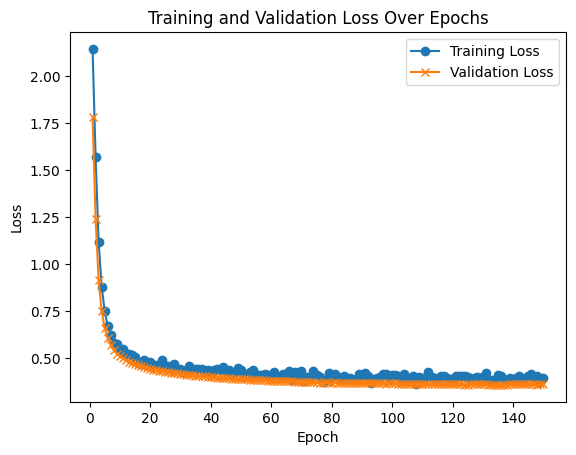

In [33]:
# Training setup
criterion = torch.nn.CrossEntropyLoss()
num_epochs = 1000

# Optimizer setup
optimizer = torch.optim.SGD(linear_classifier.parameters(), lr=0.2, momentum=0.9, nesterov=True)
total_steps = num_epochs * len(train_loader)
scheduler = LambdaLR(optimizer, lr_lambda=lambda step: get_lr(step, total_steps, 0.2, 1e-3))

linear_classifier.train()

# Early stopping setup
early_stopping_patience = 15
min_val_loss = float('inf')
epochs_no_improve = 0
epsilon = 1e-3
train_losses = []
val_losses = []

# Data preperation setup
n_classes = 10
samples_per_class = 250

for epoch in range(num_epochs):
    # Create a new subset every epoch
    indices = np.hstack([np.random.choice(np.where(np.array(train_dataset.targets) == i)[0], samples_per_class, replace=False) for i in range(n_classes)])
    sampler = SubsetRandomSampler(indices)
    train_loader = DataLoader(train_dataset, batch_size=512, sampler=sampler)

    epoch_loss = 0.0
    linear_classifier.train()

    # Training phase
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = linear_classifier(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    train_losses.append(epoch_loss)

    # Validation phase
    linear_classifier.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = linear_classifier(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    # Average validation loss for this epoch
    val_loss /= len(test_loader)
    val_losses.append(val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}')

    # Early stopping check based on validation loss
    if val_loss < min_val_loss - epsilon:
        min_val_loss = val_loss
        epochs_no_improve = 0
    elif epoch > 20:
        epochs_no_improve += 1
        if epochs_no_improve == early_stopping_patience:
            print("Early stopping triggered.")
            break

# Plot training and validation loss
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, marker='x', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()



In [ ]:
torch.save(linear_classifier.state_dict(), 'linear_classifier_state.pth')

#### Evaluating the SSL + Linear model

In [34]:
model.eval()  # Set the model to evaluation mode
linear_classifier.eval()

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = linear_classifier(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy of the model on the test images: {100 * correct / total} %')


Accuracy of the model on the test images: 88.82 %
